---
<div align="center">

# Lung Cancer Classification
</div>

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import radiomics
import customPylidc as pl

---
## Data Exploration and Extraction
---

> ADD A CONTEXT FOR THE DATA [EG: A PATIENT CAN CONTAIN MULTIPLE NODULES AS WELL AS MULTIPLE ANNOTATIONS FOR THE SAME NODULE]


---
### Dataset Dimensions
---

First of all, let's start by analysing the dataset dimensions in terms of the amount of patients, scans and annotations.

In [3]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [4]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [5]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


---
### Patient Nodules Visualization
---

Let's select the first patient and visualize how his nodules data look like.

In [6]:
# Choose a patient ID
pid = 'LIDC-IDRI-0001'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0001's Scan has 1 Nodule(s)


Loading dicom files ... This may take a moment.


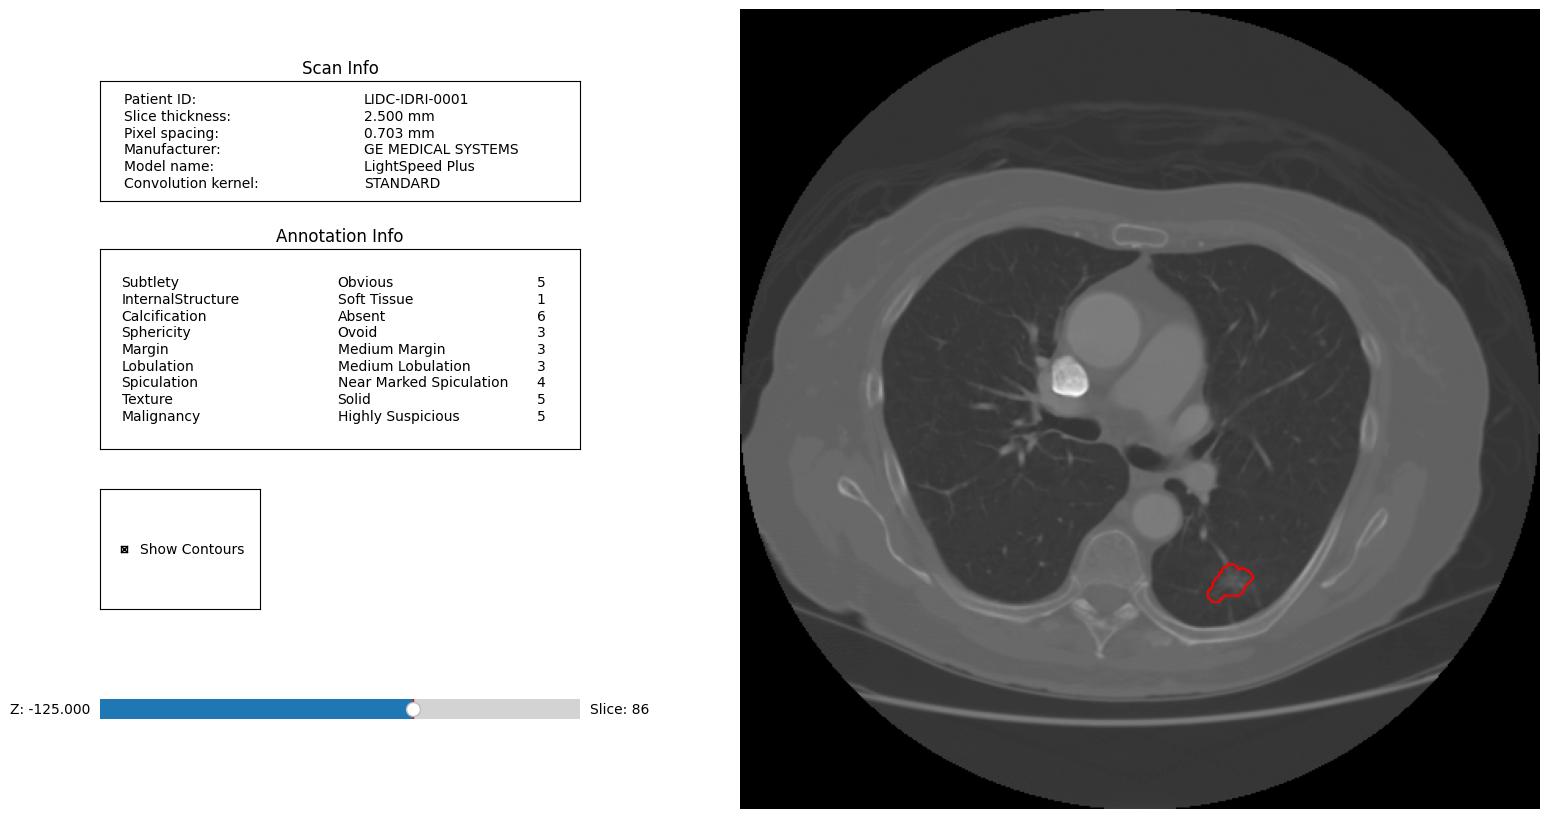

In [7]:
# Plot the 2D Scan with the Annotation info
ann.visualize_in_scan()

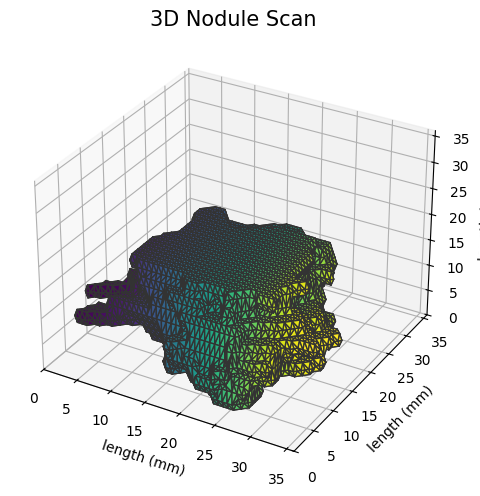

In [8]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
---
---

---
### Annotation Class Analysis
---

In [9]:
ann = pl.query(pl.Annotation).first()
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 


In [10]:
# Inspect all the attributes inside an Annotation Object
annotationParams = [param for param, paramValue in pl.Annotation.__dict__.items() if param[0] != '_' and not callable(paramValue)]
# annotationParams

Let's take a look on the first available Annotation

In [11]:
pl.query(pl.Annotation).first()

Annotation(id=1,scan_id=1)

---
### Scan Class Analysis
---

In [12]:
# Inspect all the attributes inside an Scan Object
scanParams = [param for param, paramValue in pl.Scan.__dict__.items() if param[0] != '_' and not callable(paramValue)]
# scanParams

---

python pyradiomics-dcm.py --input-image-dir "{patient}\{path}\{main}" --input-seg-file "{patient}\{path}\{folder}\\1-1.dcm" --output-dir OutputSR --temp-dir TempDir --parameters Pyradiomics_Params.yaml --features-dict featuresDict.tsv --name {patient}-{seg_index}"""')
            seg_index+=1

---
## PyLIDC Feature Extraction
---

> The package contains the semantical features

In [31]:
# Define the initial structure of the Dataframe
df_pylidc = pd.DataFrame(columns= [
                            'patient_id', # Patient Identification Number
                            'annotation_id', # Annotation Identification Number
                            'scan_id', # Scan Identification Number
                            
                            'slice_thickness',
                            'pixel_spacing',

                            'subtlety', 
                            'internalStructure', 
                            'calcification', 
                            'sphericity', 
                            'margin', 
                            'lobulation', 
                            'spiculation', 
                            'texture',
                            
                            'diameter',
                            'surface_area',
                            'volume',

                            'malignancy', # Target [What we want to predict]
                            ])
df_pylidc = df_pylidc.dropna(axis=1, how='all')

In [34]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = 'pylidc_features.csv'

# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(f'./{pylidcFeaturesFilename}'):

    # Fetch all the Annotations Available
    ann = pl.query(pl.Annotation).all()
    
    for i in range(len(ann)):
        # Initialize a dictionary with the df's attributes / columns and empty strings
        att  = dict((col, "") for col in df_pylidc.columns)
    
        # Saving the personal identifiable identification [PII]
        att['patient_id'] = ann[i].scan.patient_id
        att['annotation_id'] = ann[i].id  
        att['scan_id'] = ann[i].scan.id
        
        # -> Fetch and Save the Nodule's characteristics [Features]

        # Get and Save the slice thickness
        st = pl.query(pl.Scan.slice_thickness).filter(pl.Scan.id == att['scan_id'])
        s = str(st[0])
        att['slice_thickness'] = float(s[1:4])

        # Get and Save the pixel spacing
        ps = pl.query(pl.Scan.pixel_spacing).filter(pl.Scan.id == att['scan_id'])
        p = str(ps[0])
        att['pixel_spacing'] = float(p[1:5])

        # Saving remaining values
        att['subtlety'] = ann[i].subtlety
        att['internalStructure'] = ann[i].internalStructure 
        att['calcification'] = ann[i].calcification 
        att['sphericity'] = ann[i].sphericity
        att['margin'] = ann[i].margin  
        att['lobulation'] = ann[i].lobulation
        att['spiculation'] = ann[i].spiculation 
        att['texture'] = ann[i].texture
        att['diameter'] = ann[i].diameter
        att['surface_area'] = ann[i].surface_area
        att['volume'] = ann[i].volume
    
        # Target
        att['malignancy'] = ann[i].malignancy  

        # Convert the new row into a Dataframe and add it to the previous one
        df_att = pd.DataFrame.from_dict([att])
        df_pylidc = pd.concat([df_pylidc, df_att], ignore_index=True)

    # Save the results into a .csv file
    df_pylidc.to_csv(pylidcFeaturesFilename, sep=',', index=False)

---
## Pyradiomics Feature Extraction
---

> Describe the extraction setup and what we aim to gain from it. What was used (Packages, other resources, ....)
> Perform the extraction with the images and merge the results with the previous dataset
> Clean the Data and save it

In [ ]:
# CODE HERE

---

## TODO:
- Identify and Describe the Problem
- Identify the business, its goals and possible constraints for the solution and the used pipeline
- Weight the 2D vs 3D image processing paradigm and choose which one to use and why

<br/>

- Perform Exploratory Data Analysis [Class Imbalance, Check type of problem - if we can switch from multi-class to binary classification, maybe perform synthetic sampling or data prunning, If there is a lot of data maybe consider a PCA to reduce processing costs]
- Select Algorithms and the reasons behind the choice
- Split the data based on a K-Fold Cross Validation Stratigy
- Perform Grid Search for parameter tunning on each one of the algorithms
- Train the model with the best hyperparameters found and evaluate the performance based on multiple metrics [balanced accuracy, f1-score, ...]
- Perform a statistical evaluation on the model's performance
- Does it achieve the business goals and at what costs?
- Ethical Considerations and identify possible privacy breaches (even though the data is anonimized)
- YouTube Presentation Video
- Bibliographic References